Use machine learning models to detect steel manufacturing defects in microscopic images.
May help automate defect detection process and increase accuracy.
12568 training images are provided at Kaggle website below, as an ongoing competition.
https://www.kaggle.com/c/severstal-steel-defect-detection
Defect location and defect class info are provided in a csv file, in Run-Length Encoding (RLE) format
Each image can have no defect, one class of defect or up to four classes of defects


## EDA

In [1]:
import numpy as np
import pandas as pd 

In [2]:
# read in csv file with defect info in RLE (Run Length Encoding) format
train_img_path = "./train_images/"
train_csv = "./train.csv"
df = pd.read_csv(train_csv)
df_train = df.sort_values(by=['ImageId_ClassId'])
df_train['EncodedPixels'].astype(str)
print(df_train.head())

   ImageId_ClassId                                      EncodedPixels
0  0002cc93b.jpg_1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0002cc93b.jpg_2                                                NaN
2  0002cc93b.jpg_3                                                NaN
3  0002cc93b.jpg_4                                                NaN
4  00031f466.jpg_1                                                NaN


In [3]:
# split ImageID and defect ClassID
df_train['ImageId'] = df_train['ImageId_ClassId'].apply(lambda s:s.split("_")[0])
df_train['Labels'] =  df_train['ImageId_ClassId'].apply(lambda s:int(s.split("_")[1]))
print(df_train.head())

# find out how many lines in csv file have defects
df_train_encoded_only = df_train[~df_train['EncodedPixels'].isnull()].reset_index(drop=True)  # get only image with labeled data for defects
print(df_train_encoded_only.head())
print(df_train_encoded_only.shape)
print(df_train.shape)

   ImageId_ClassId                                      EncodedPixels  \
0  0002cc93b.jpg_1  29102 12 29346 24 29602 24 29858 24 30114 24 3...   
1  0002cc93b.jpg_2                                                NaN   
2  0002cc93b.jpg_3                                                NaN   
3  0002cc93b.jpg_4                                                NaN   
4  00031f466.jpg_1                                                NaN   

         ImageId  Labels  
0  0002cc93b.jpg       1  
1  0002cc93b.jpg       2  
2  0002cc93b.jpg       3  
3  0002cc93b.jpg       4  
4  00031f466.jpg       1  
   ImageId_ClassId                                      EncodedPixels  \
0  0002cc93b.jpg_1  29102 12 29346 24 29602 24 29858 24 30114 24 3...   
1  0007a71bf.jpg_3  18661 28 18863 82 19091 110 19347 110 19603 11...   
2  000a4bcdd.jpg_1  37607 3 37858 8 38108 14 38359 20 38610 25 388...   
3  000f6bf48.jpg_4  131973 1 132228 4 132483 6 132738 8 132993 11 ...   
4  0014fce06.jpg_3  229501 11 2297

In [4]:
# find out how many images have defects for each defect Class
print(df_train.groupby('Labels')['EncodedPixels'].count())
print(df_train['Labels'].value_counts())

Labels
1     897
2     247
3    5150
4     801
Name: EncodedPixels, dtype: int64
4    12568
3    12568
2    12568
1    12568
Name: Labels, dtype: int64


In [5]:
"""
This function is an rle to mask converter.
You supply the rle string for one mask, along with it's height and width
from the solutions for stage1 and it will return the mask.
"""

def rleToMask(rleString,height,width):
  
    rows,cols = height,width
    img = np.zeros(rows*cols,dtype=np.uint8)
    if str(rleString) != 'nan':
        rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        for index,length in rlePairs:
            index -= 1
            img[index:index+length] = 1
    img = img.reshape(cols,rows)
    img = img.T
    return img

In [6]:
# Set image dimension parameters
im_height = 256
im_width = 1600

Text(0.5, 1.0, 'Steel Image, Defect 3')

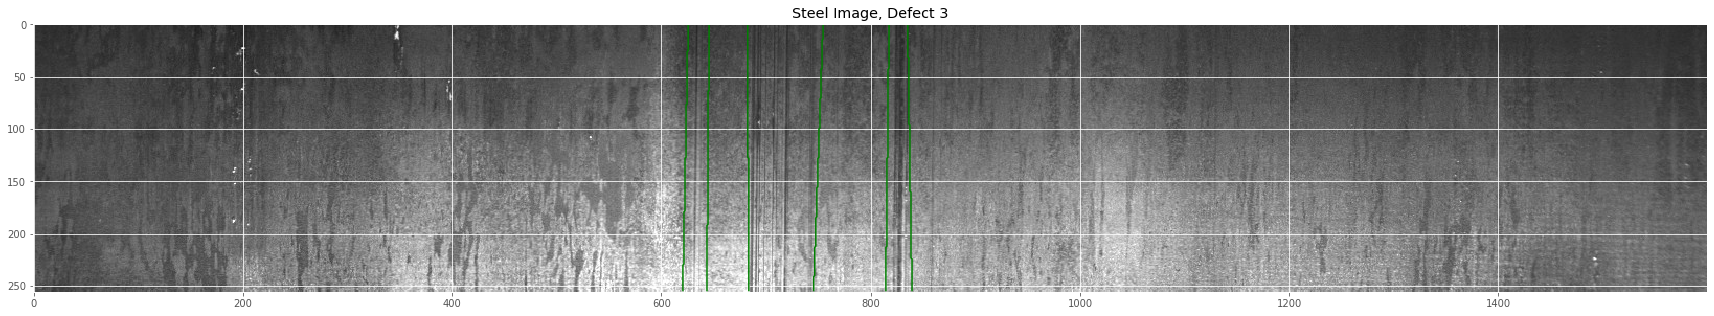

In [14]:
import random
import matplotlib.pyplot as plt
# plot images with masks to explore what defects look like
# randomly choose one defect image
ix = random.randint(0, df_train_encoded_only.shape[0])
img = plt.imread("./train_images/"+df_train_encoded_only['ImageId'][ix])

# Load masks
mask = rleToMask(df_train_encoded_only['EncodedPixels'][ix], im_height, im_width)
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
plt.imshow(img)
plt.contour(mask.squeeze(), colors='g', levels=[0.5])
plt.title('Steel Image, Defect ' + str(df_train_encoded_only['Labels'][ix]))

## Prepare data and functions for modeling

In [8]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import array_to_img, img_to_array, load_img

c:\users\kevin\anaconda3\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\kevin\anaconda3\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\kevin\anaconda3\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\kevin\anaconda3\envs\tensorflow_cpu\l

In [9]:
from tensorflow.keras import backend as K

# utility functions for training metrics
def neg_dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return -(2*intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 2 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def diff(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    return K.abs( K.sum( y_true_f-y_pred_f))

In [10]:
def data_generator(df_train_def):
    """ generate data matrices to prepare X and label y """
    n_images = len(df_train_def)
    X = np.zeros((n_images, 128, 800, 1), dtype=np.float32)
    y = np.zeros((n_images, 128, 800, 1), dtype=np.int8)
    print('memory OK')
    
    for i in range(n_images):
        # Load images
        img = load_img("./train_images/"+df_train_def['ImageId'][i], grayscale=True)
        x_img = img_to_array(img)
        x_img = cv2.resize(x_img, (800, 128))
        x_img = x_img.reshape(128, 800, 1)

        # Load masks
        mask = rleToMask(df_train_def4['EncodedPixels'][i], im_height, im_width)
        mask = cv2.resize(mask, (800, 128))
        mask = mask.reshape(128, 800, 1)

        # Save images
        X[i] = x_img/255.0
        y[i] = mask
        
    return X, y

In [11]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [12]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [13]:
def model_compile_fit(X_train, y_train, X_valid, y_valid, model_name):
    """ compile and fit model """
    input_img = Input((128, 800, 1), name='img')
    model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
    model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss=neg_dice_coef, \
                  metrics=[diff, "binary_accuracy"])
    model.summary()
    
    callbacks = [
    EarlyStopping(patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00005, verbose=1),
    ModelCheckpoint(model_name, verbose=1, save_best_only=True, save_weights_only=True)]
    
    results = model.fit(X_train, y_train, batch_size=32, epochs=10, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))
    
    return model, results 

## Modeling

In [13]:
# Work on defect 1
df_train_def1 = df_train[df_train['Labels']==1].reset_index(drop=True)
print(df_train_def1.shape)
def1_X, def1_y = data_generator(df_train_def1)
print('data generator done')
def1_X_train, def1_X_valid, def1_y_train, def1_y_valid = train_test_split(def1_X, def1_y, test_size=0.3, random_state=42)
def1_model, def1_results = model_compile_fit(def1_X_train, def1_y_train, def1_X_valid, def1_y_valid, 'model-defect1.h5')

# Work on defect 2
df_train_def2 = df_train[df_train['Labels']==2].reset_index(drop=True)
print(df_train_def2.shape)
def2_X, def2_y = data_generator(df_train_def2)
print('data generator done')
def2_X_train, def2_X_valid, def2_y_train, def2_y_valid = train_test_split(def2_X, def2_y, test_size=0.3, random_state=42)
def2_model, def2_results = model_compile_fit(def2_X_train, def2_y_train, def2_X_valid, def2_y_valid, 'model-defect2.h5')

# Work on defect 3
df_train_def3 = df_train[df_train['Labels']==3].reset_index(drop=True)
print(df_train_def3.shape)
def3_X, def3_y = data_generator(df_train_def3)
print('data generator done')
def3_X_train, def3_X_valid, def3_y_train, def3_y_valid = train_test_split(def3_X, def3_y, test_size=0.3, random_state=42)
def3_model, def3_results = model_compile_fit(def3_X_train, def3_y_train, def3_X_valid, def3_y_valid, 'model-defect3.h5')

# Work on defect 4
df_train_def4 = df_train[df_train['Labels']==4].reset_index(drop=True)
print(df_train_def4.shape)
def4_X, def4_y = data_generator(df_train_def4)
print('data generator done')
def4_X_train, def4_X_valid, def4_y_train, def4_y_valid = train_test_split(def4_X, def4_y, test_size=0.3, random_state=42)
def4_model, def4_results = model_compile_fit(def4_X_train, def4_y_train, def4_X_valid, def4_y_valid, 'model-defect4.h5')



(12568, 4)
memory OK


c:\users\kevin\anaconda3\envs\tensorflow_cpu\lib\site-packages\keras_preprocessing\image\utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


data generator done
(8797, 128, 800, 1) (8797, 128, 800, 1)
(3771, 128, 800, 1) (3771, 128, 800, 1)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 800, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 800, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 800, 16) 64          conv2d_2[0][0]                   
___________________________________________________________________

Train on 8797 samples, validate on 3771 samples
Epoch 1/10
8797/8797 [==============================] - 5343s 607ms/step - loss: -0.0335 - diff: 868900.3571 - binary_accuracy: 0.8601 - val_loss: -0.0282 - val_diff: 1122580.4455 - val_binary_accuracy: 0.7225

Epoch 00001: val_loss improved from inf to -0.02823, saving model to model-defect4.h5
Epoch 2/10
8797/8797 [==============================] - 5267s 599ms/step - loss: -0.1325 - diff: 130677.1037 - binary_accuracy: 0.9726 - val_loss: -0.1024 - val_diff: 68785.6236 - val_binary_accuracy: 0.9737

Epoch 00002: val_loss improved from -0.02823 to -0.10242, saving model to model-defect4.h5
Epoch 3/10
8797/8797 [==============================] - 5262s 598ms/step - loss: -0.2467 - diff: 20896.9601 - binary_accuracy: 0.9901 - val_loss: -0.2042 - val_diff: 97807.5889 - val_binary_accuracy: 0.9678

Epoch 00003: val_loss improved from -0.10242 to -0.20415, saving model to model-defect4.h5
Epoch 4/10
8797/8797 [==============================] - 

## Model evaluation

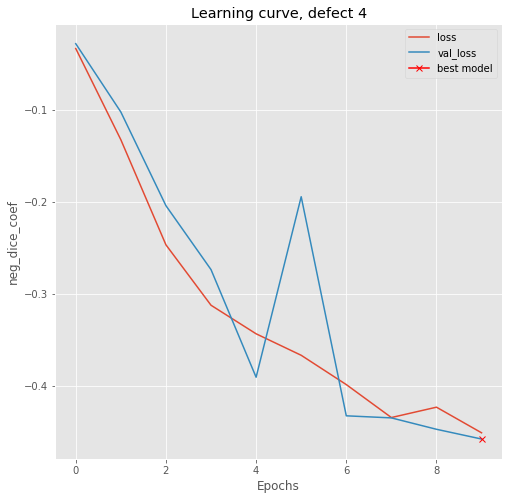

In [15]:
# plot learning curves
plt.figure(figsize=(8, 8))
plt.title("Learning curve, defect 4")
plt.plot(def4_results.history["loss"], label="loss")
plt.plot(def4_results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(def4_results.history["val_loss"]), np.min(def4_results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("neg_dice_coef")
plt.legend();

In [18]:
# Predict on train, val and test
#preds_train = model.predict(X_train, verbose=1)
def4_preds_val = def4_model.predict(def4_X_valid, verbose=1)

3771/3771 [==============================] - 501s 133ms/step


In [19]:
# Threshold predictions
#preds_train_t = (preds_train > 0.5).astype(np.uint8)
def4_preds_val_t = (def4_preds_val > 0.5).astype('int8')

In [23]:
# dice coef function that works to calculate image level dice coef
def dice_coef2(y_true, y_pred):
    smooth = 1
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = (y_true_f * y_pred_f).sum()
    return (2*intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

In [24]:
# calculate mean dice coef for imageID-defect ClassID combination
def mean_image_defectClass_dice_coef(y_valid, preds_val_t):
    dice = np.zeros(len(y_valid))
    for ix in range(len(y_valid)):
        dice[ix] = dice_coef2(y_valid[ix], preds_val_t[ix])
    
    print(dice.shape)
    print(dice.mean())
    return dice.mean()

In [25]:
mean_dice_coef_def4 = mean_image_defectClass_dice_coef(def4_y_valid, def4_preds_val_t)

(3771,)
0.8904714366105121
